In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
import trompy as tp
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
%matplotlib inline

In [16]:
DATAPATH = Path("C://Data//hislight_pickles//HL3_restricted_dark.pickle")

with open(DATAPATH, 'rb') as handle:
    HL3_restricted_dark = pickle.load(handle)

In [17]:
mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                  "HL301", "HL304", "HL305"]

#HL313 - HL318 are control mice
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement

In [18]:
list_of_mice = []

for key, val in HL3_restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in list_of_mice :
            list_of_mice.append(val["mouse_ID"])

In [23]:
list_of_mice = ['HL302', 'HL307', 'HL309', 'HL310', 'HL312']

In [24]:
def get_snips(data):

    snips_mean_start= []
    snips_mean_end = []
    snips_mean_full = []

    kwargs={"bins":150, "trial_length":15, "baseline_length":5}   

    pre = 5
    post = 10
    mineventlength=10
    binlength=0.1

    for mouse in list_of_mice:
        snips_start = []
        snips_end = []
        snips_full = []

        for key, val in data.items():
            if val["mouse_ID"]==mouse:
                if len(val["licks"]) < 10:
                    continue

                lickdata= tp.lickCalc(val["licks"], minrunlength=3)

                snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
                snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

                snipper = tp.Snipper(val["corrected"],
                                        lickdata["rStart"],
                                        end=lickdata["rEnd"],
                                        fs=val["fs"],
                                        pre=pre,
                                        post=post,
                                        binlength=binlength,
                                        zscore=True
                                        )

                snipper.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength)
                snipper.find_potential_artifacts(threshold=8, method="sum")
                snips_full.append(snipper.snips)


        snips_start = np.vstack(snips_start)
        snips_end = np.vstack(snips_end)
        
        try:
            snips_full = np.vstack(snips_full)
            snips_mean_full.append(np.mean(snips_full, axis=0))
            print("adding this mouse")
        except:
            print("no snips to concatenate")

        snips_mean_start.append(np.mean(snips_start, axis=0))
        snips_mean_end.append(np.mean(snips_end, axis=0))
   
    snips_mean_full = np.array(snips_mean_full)
    
    return snips_mean_start, snips_mean_end, snips_mean_full

In [25]:
snips_mean_start, snips_mean_end, snips_mean_full = get_snips(HL3_restricted_dark)

<class 'numpy.ndarray'>
Found 13 potential artifacts.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
Found 5 potential artifacts.
<class 'numpy.ndarray'>
Found 8 potential artifacts.
<class 'numpy.ndarray'>
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)



adding this mouse
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 2 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Found 1 potential artifacts.
<class 'numpy.ndarray'>
Found 1 potential artifacts.
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


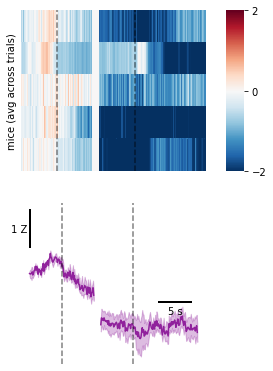

In [26]:
f,[[ax1, ax2], [ax3, ax4]]=plt.subplots(nrows=2, ncols=2,
                                        figsize=[4,6.5],
                                        gridspec_kw={"width_ratios":[10,1]})

pre = 5
post = 10
mineventlength=10
binlength=0.1


sns.heatmap(snips_mean_full, ax=ax1, cbar_ax= ax2, cmap="RdBu_r", vmax=2, vmin=-2, cbar_kws={"ticks": [2, 0, -2]})

bins_early = int((pre + mineventlength/2)/binlength)
bins_late = int((post + mineventlength/2)/binlength)

x1 = np.arange(0,bins_early)
x2 = np.arange(snips_mean_full.shape[1] - bins_late, snips_mean_full.shape[1])

mean = np.mean(snips_mean_full, axis=0)
error_values = np.std(snips_mean_full, axis=0) / np.sqrt(len(snips_mean_full))

color="#90219c"

ax3.plot(x1, mean[:bins_early], color=color)
ax3.plot(x2, mean[-bins_late:], color=color)
ax3.fill_between(x1, mean[:bins_early]-error_values[:bins_early], mean[:bins_early]+error_values[:bins_early], color=color, alpha=0.3)
ax3.fill_between(x2, mean[-bins_late:]-error_values[-bins_late:], mean[-bins_late:]+error_values[-bins_late:], color=color, alpha=0.3)

ax4.remove()

ax1.set_yticks([])
ax1.set_xticks([])
ax1.axvline(50, color="k", linestyle="--", alpha=0.5)
ax1.axvline(160, color="k", linestyle="--", alpha=0.5)

ax3.set_yticks([])
ax3.set_xticks([])

ax1.set_ylabel("mice (avg across trials)")

for spine in ["top", "right", "left", "bottom"]:
    ax3.spines[spine].set_visible(False)

ax3.plot([200,250], [-1,-1], linewidth=2, color="k")
ax3.text(225,-1.1,"5 s", va="top", ha="center")

ax3.plot([0,0], [0.5, 1.5], linewidth=2, color="k")
ax3.text(-3, 1, "1 Z", va="center", ha="right")

ax3.axvline(50, color="k", linestyle="--", alpha=0.5)
ax3.axvline(160, color="k", linestyle="--", alpha=0.5)

#f.savefig("C:\\Users\\kvo019\\OneDrive - UiT Office 365\\Pipette 2\\People\\Linnea\\Manuscripts\\hislight paper\\figures\\HL3_grouped.pdf")